In [1]:
# Формирование автоматического отчета 

# Подготовительные действия

# 1. Заходим в командную строку Anaconda Prompt и выполняем следующую команду: 
# для Windows 
#pip install psycopg2
# для MacOS
# pip install psycopg2-binary

# Создаем соединение Python с базой данных
# import getpass для скрытия пароля (необязательная команда)

import psycopg2 
import getpass  
conn=psycopg2.connect(user='postgres',
                      database='postgres', #проверяем, чтобы название совпадало с названием в вашей БЗ
                      host='localhost',
                      port='5432',
                      password=getpass.getpass('Insert password: ')
                        )
print(conn.get_dsn_parameters())

Insert password: ········
{'user': 'postgres', 'dbname': 'postgres', 'host': 'localhost', 'port': '5432', 'tty': '', 'options': '', 'sslmode': 'prefer', 'sslcompression': '0', 'krbsrvname': 'postgres', 'target_session_attrs': 'any'}


In [2]:
# Генерация таблицы (из Дз_3) для отчета

import pandas as pd

query1="select public.ratings_info.\"rat_key\", \"rat_id\", \"agency_id\", \"grade\", \"change\", \"date\", \"ent_id\", \"grade_id\", \"default\" from public.ratings_info inner join (select \"rat_key\", \"grade\", \"change\", public.ratings_task.\"date\", public.ratings_task.\"ent_id\", \"grade_id\", \"event\" as \"default\" from public.ratings_task left join (select * from public.credit_events_task WHERE \"event\"='dft' AND \"ent_id\" IS NOT NULL AND \"date\" >= '11.11.2014' AND \"date\" <= '11.11.2016') as tbl2 on public.ratings_task.\"ent_id\"=tbl2.\"ent_id\" WHERE public.ratings_task.\"date\" >= '11.11.2014' AND public.ratings_task.\"date\" <= '11.11.2016') as tb1 on public.ratings_info.\"rat_key\"=tb1.\"rat_key\" where \"change\" <> 'снят'  and \"change\" <> 'приостановлен' and \"rat_id\" = 14 and \"agency_id\" = 'EXP';"
tbl1=pd.read_sql_query(query1,conn)
group1=tbl1.groupby(['grade_id']).count()
tbl2=tbl1[['grade_id', 'rat_key', 'rat_id', 'agency_id', 'grade', 'change', 'date', 'ent_id', 'default']][(tbl1['default']!='dft')]
tbl2 = tbl2.rename(columns = {tbl2.columns[-1] : 'non-default'})
tbl2['non-default'] = pd.to_numeric(tbl2['non-default'], errors='coerce')
tbl2=tbl2.fillna(1)
group2=tbl2.groupby(['grade_id']).count()
group=pd.merge(group1,group2, on='grade_id',how='inner').sort_values('grade_id', ascending=False)
dist1=group[['default','non-default']]
query_add="SELECT * FROM public.scale_exp_task;"
tbl_add=pd.read_sql_query(query_add,conn)
dist2=pd.merge(dist1,tbl_add, on ='grade_id',how='inner').sort_values('grade_id', ascending=False)
dist=dist2[['grade','default', 'non-default']]
dist = dist.rename(columns = {dist.columns[0] : 'rating'})
dist

,rating,default,non-default
0,E,33,2
1,C+,4,1
2,C++,12,1
3,B,20,7
4,B+,32,39
5,B++,60,182
6,A,22,212
7,A+,3,60
8,A++,2,19


<function matplotlib.pyplot.show(*args, **kw)>

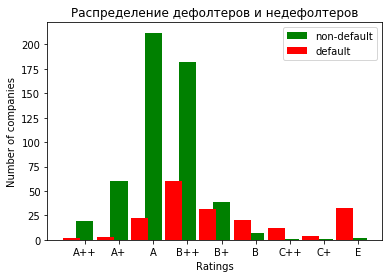

In [4]:
# Генерация графика (из Дз_3) для отчета

import matplotlib.pyplot as plt # импортируем библиотеку для построения графиков

bar1=plt.bar(dist['rating'].index, dist['non-default'], width=0.5, label='non-default', color='g')
bar2=plt.bar(dist['rating'].index+0.4, dist['default'], width=0.5, label='default', color='r')

plt.xlabel('Ratings')
plt.ylabel('Number of companies')
plt.title('Распределение дефолтеров и недефолтеров')
plt.xticks(dist['rating'].index, dist['rating'])
plt.gca().invert_xaxis() #сортируем рейтинги в порядке ухудшения.
plt.legend()

plt.savefig('default_and_non-default_distribution.png') # сохранение картинки в рабочую директорию
plt.show

In [ ]:
# Действия перед генерацией отчета

# Install jinja2 and weasyprint in Anaconda prompt
# pip install jinja2
# pip install weasyprint

# 1. В Anaconda Prompt выполнить pip install --upgrade pip setuptools
# 2. Установка c настройками по умолчанию 
# https://github.com/tschoonj/GTK-for-Windows-Runtime-Environment-Installer/releases/download/2019-11-07/gtk3-runtime-3.24.12-2019-11-07-ts-win64.exe
# 3. Добавление папки в путь Python (исполнить команды в Anaconda Propmpt):
# SET PROPER_GTK_FOLDER='C:\Program Files\GTK3-Runtime Win64\bin'
# SET PATH=%PROPER_GTK_FOLDER%;%PATH%
# PATH (убедиться, что в списке директорий появилась добавленная)
# 4. Перезапустить Python и исполнить код с генерацией отчета ниже.

In [ ]:
# Собираем автоматический отчет в виде pdf

from __future__ import print_function
from jinja2 import Environment, FileSystemLoader
from weasyprint import HTML, Document
import os

env = Environment(loader=FileSystemLoader('.')) 
template = env.get_template("myreport.html") # Шаблон сохранен в рабочей директории 
template_vars = {"title": "Отчет составлен Смирновой Дарьей", # Заголовок для отчета
                "INTRO": "Данный отчет содержит информацию о распределении дефолтеров и недефолтеров за период 11.11.2014-11.11.2016 для типа рейтинга rat_id=24.", # Аннотация для начала отчета
                 "TABLE_DESC": "В таблице представлено распределение дефолтеров и недефолтеров за период 11.11.2014-11.11.2016 для типа рейтинга 24", # Подпись к таблице в отчете
                 "TABLE": dist.to_html(), # Перевод таблицы в формат html
                 "IMAGE_DESC": "На гистограмме изображена визуализация распределения",  # Подпись к гистограмме в отчете
                 "IMAGE": os.path.realpath('default_and_non-default_distribution.png') # Путь, где сохранен рисунок. Данный код подразумевает, что картинка хранится в рабочей папке.
                }

# Собираем и печатаем репорт
html_out = template.render(template_vars, presentational_hints=True)
HTML(string=html_out).write_pdf('Default_and_non-default_distribution.pdf', presentational_hints=True)
